In [2]:
import numpy as np
import pandas as pd
import cv2
import os
from sklearn.metrics import classification_report, confusion_matrix
import random
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense,BatchNormalization, Flatten, MaxPool2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from tensorflow.keras.utils import Sequence
from keras.backend import epsilon
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import os

import warnings

warnings.filterwarnings('ignore')



from tensorflow.keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt
from PIL import ImageFile



In [2]:
Class = os.listdir("YOGA/content/cleaned/DATASET/TRAIN")
Class

['downdog', 'goddess', 'plank', 'tree', 'warrior2']

In [3]:
IMAGE_SIZE = 224
CHANNELS = 3 # nbr of color RGB

train_datagen = ImageDataGenerator(
        rescale = 1./255,# the pixel values of the images are divided by 255, effectively rescaling them to the range of 0 to 1
        horizontal_flip = True,
        rotation_range = 10
)
train_generator = train_datagen.flow_from_directory(
    'YOGA/content/cleaned/DATASET/TRAIN',
    target_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = 32,
    class_mode = 'categorical',
)

Found 1075 images belonging to 5 classes.


In [4]:
test_datagen = ImageDataGenerator(
        rescale = 1./255,
        horizontal_flip = True,
        rotation_range = 10
)
test_generator = test_datagen.flow_from_directory(
    'YOGA/content/cleaned/DATASET/TEST',
    target_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = 32,
    class_mode = 'categorical',
)

Found 466 images belonging to 5 classes.


# VGG16

In [6]:
input_shape = (IMAGE_SIZE,IMAGE_SIZE,CHANNELS)

pre_trained_model = VGG16(
    input_shape = input_shape,
    include_top = False, # the pre-trained model does not include the fully connected layers
    weights = "imagenet" # use pre trained weights imagenet
)

for layer in pre_trained_model.layers:
    layer.trainable = False
## means their weights will not be updated during training.     

pre_trained_model.summary()

58889256/58889256 [==============================] - 41s 1us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                             

In [7]:
model = tf.keras.models.Sequential([
    pre_trained_model,
    
    Flatten()## 2D => 1D ,    
    Dense(256,activation="relu"),
    BatchNormalization(), # normalizes the inputs to a layer
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                        

In [8]:
model.compile(
            optimizer="adam",
            loss='categorical_crossentropy',
            metrics = ['acc']
)

In [9]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [10]:
history = model.fit_generator(
            train_generator,
            validation_data=test_generator,
            epochs=8
)

Epoch 1/8
34/34 [==============================] - 476s 14s/step - loss: 0.8828 - acc: 0.7219 - val_loss: 1.6811 - val_acc: 0.6652
Epoch 2/8
34/34 [==============================] - 469s 14s/step - loss: 0.3523 - acc: 0.9005 - val_loss: 0.4697 - val_acc: 0.8605
Epoch 3/8
34/34 [==============================] - 474s 14s/step - loss: 0.2358 - acc: 0.9321 - val_loss: 0.2600 - val_acc: 0.9185
Epoch 4/8
34/34 [==============================] - 419s 12s/step - loss: 0.1799 - acc: 0.9526 - val_loss: 0.2895 - val_acc: 0.9056
Epoch 5/8
34/34 [==============================] - 360s 11s/step - loss: 0.1179 - acc: 0.9684 - val_loss: 0.1441 - val_acc: 0.9528
Epoch 6/8
34/34 [==============================] - 343s 10s/step - loss: 0.1092 - acc: 0.9674 - val_loss: 0.1461 - val_acc: 0.9506
Epoch 7/8
34/34 [==============================] - 339s 10s/step - loss: 0.0715 - acc: 0.9833 - val_loss: 0.1554 - val_acc: 0.9485
Epoch 8/8
34/34 [==============================] - 340s 10s/step - loss: 0.0866 - a

Text(0.5, 1.0, 'Training and validation loss')

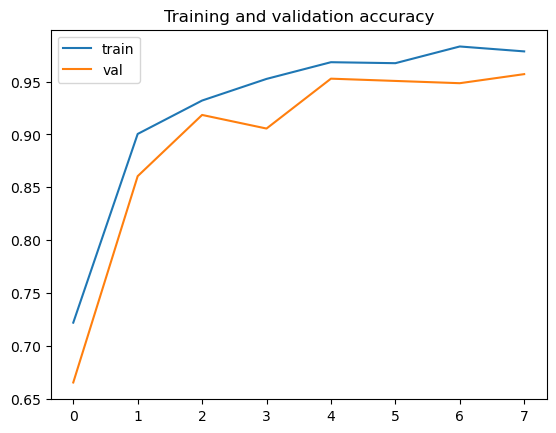

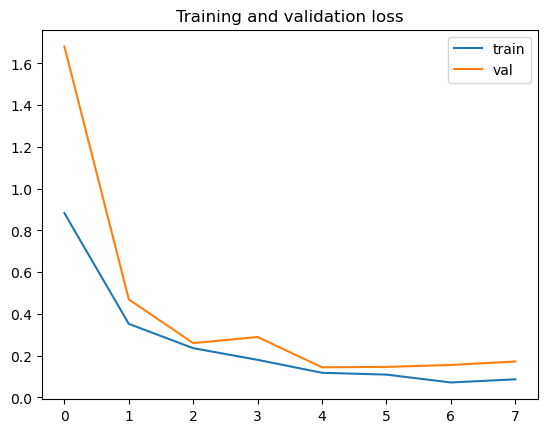

In [11]:
acc      = history.history['acc']
val_acc  = history.history['val_acc']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs,acc)
plt.plot(epochs,val_acc)
plt.title('Training and validation accuracy')
plt.legend(['train','val'])
plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs,loss)
plt.plot(epochs,val_loss)
plt.legend(['train','val'])
plt.title('Training and validation loss')

In [12]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc   = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , Test accuracy = {:.2f}".format(train_acc*100, test_acc*100))

15/15 [==============================] - 105s 7s/step - loss: 0.1688 - acc: 0.9635
final train accuracy = 99.35 , Test accuracy = 96.35


In [13]:
model.save('YogaVGG16_model.h5')

In [4]:
from keras.models import load_model
from keras.applications.vgg16 import preprocess_input
model = load_model('YogaVGG16_model.h5')
img = image.load_img('00000000.jpg', target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img_data = preprocess_input(x)
classes = model.predict(img_data)
print(classes) 

1/1 [==============================] - 0s 327ms/step
[[0. 0. 0. 0. 1.]]
